In [3]:
import cv2
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score

In [4]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [5]:
import os
# print(os.getcwd())

In [6]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # 防止佔滿 GPU 記憶體
    except RuntimeError as e:
        print(e)


In [7]:
seed=42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [8]:
def showData(path,title=''):
    image = img.imread(path)
    #避免多通道或單通道無法正常顯示
    if len(image.shape)==2:
        image = image.reshape((image.shape[0],image.shape[1],1))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        if image.shape[-1]==4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            
    if title !='':
        plt.title(title)
    plt.show()

### 載入資料集

In [9]:
lst_labels = ['covid','normal','pneumonia']
dic = {'image_path':[],'labels':[]}
for lbl in lst_labels:
    folder = f"/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset/{lbl}/"
    for name in os.listdir(folder):
        dic['image_path'].append(folder+name)
        dic['labels'].append(lst_labels.index(lbl))

df_dataest = pd.DataFrame(dic)
df_dataest['labels'] = df_dataest['labels'].astype(int)

### 觀察類別平衡情況

In [10]:
print(len(df_dataest))
df_dataest['labels'].value_counts()

6939


labels
0    2313
1    2313
2    2313
Name: count, dtype: int64

In [11]:
def load_data(img_paths,img_size):
    '''
    1.將圖片轉型縮放成只指定大小
    2.解決將多通道或單通道的圖片統一成RGB三通道
    3.遇到已經過好標準化(0-1)的圖片的話先轉回來(0-255)方便後續SHAP觀察 
    '''
    lst = []
    for p in img_paths:
        image = img.imread(p)
        image = cv2.resize(image, img_size)
        # 處理不同通道的輸入資料
        #
        if len(image.shape)==2:
            image = image.reshape((img_size[0],img_size[1],1))
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            if image.shape[-1]==4:
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

        #方便後續用SHAP觀察使用，發現有標準化資料先轉回來
        if image[0][0][0]<=1:
            image = (image*255.0).astype(np.uint8)
        lst.append(image)
        
    ary = np.array(lst)

    print(ary.shape)
    return ary

def to_y_data(data,num_classes):
    count = len(data)
    ary = np.zeros((len(data), num_classes),dtype=int)

    for i in range(count):
        ary[i][data[i]]=1
    return ary

In [12]:
#設定訓練資料的尺寸和model輸入的大小 
image_w_h = 256

In [13]:
data = df_dataest.sample(1000,random_state=42)

In [14]:
data['labels'].value_counts()

labels
0    346
1    340
2    314
Name: count, dtype: int64

In [15]:
X_train, X_val, y_train, y_val = train_test_split(data['image_path'], data['labels'], test_size=0.2, random_state=42)
X_train_img = load_data(X_train,(image_w_h,image_w_h))
X_val_img = load_data(X_val,(image_w_h,image_w_h))

#標準化：降低模型加速收斂
X_train = X_train_img/255.0
X_val = (X_val_img/255.0)


#轉換成類別標籤
y_train = to_y_data(y_train.to_list(),3)
y_val = to_y_data(y_val.to_list(),3)


(800, 256, 256, 3)
(200, 256, 256, 3)


In [16]:
print('X_train',X_train.shape,'y_train',y_train.shape)
print('X_val  ',X_val.shape,' y_val  ',y_val.shape)

X_train (800, 256, 256, 3) y_train (800, 3)
X_val   (200, 256, 256, 3)  y_val   (200, 3)


In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.applications.VGG16(include_top = False,input_shape = (image_w_h,image_w_h,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(50, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
model.layers[0].freeze=True
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy','auc','recall','precision'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │       1,638,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,484,563 (62.88 MB)

 Trainable params: 16,418,927 (62.63 MB)

 Non-trainable params: 65,636 (256.39 KB)

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',
                                            restore_best_weights=True,min_delta=0.05,
                                            patience=3)

In [19]:
history = model.fit(X_train, y_train,batch_size=50,validation_data=(X_val,y_val), epochs=20,callbacks=[callback])

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.4665 - auc: 0.6800 - loss: 1.1515 - precision: 0.4936 - recall: 0.4141 - val_accuracy: 0.5600 - val_auc: 0.7829 - val_loss: 0.8951 - val_precision: 0.6667 - val_recall: 0.3900
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8921 - auc: 0.9745 - loss: 0.3053 - precision: 0.8988 - recall: 0.8760 - val_accuracy: 0.6750 - val_auc: 0.8698 - val_loss: 0.7758 - val_precision: 0.8320 - val_recall: 0.5200
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9656 - auc: 0.9958 - loss: 0.1532 - precision: 0.9701 - recall: 0.9480 - val_accuracy: 0.7550 - val_auc: 0.9133 - val_loss: 0.7168 - val_precision: 0.8984 - val_recall: 0.5750
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9841 - auc: 0.9996 - loss: 0.0884 - precision: 0.9869 - recall: 0.9806 - val_accuracy: 0.8300 - val_auc: 0.9374 - val_loss: 0.6685 - val_precision: 0.9191 - val_recall: 0.6250
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

In [20]:
df_hostory = pd.DataFrame(history.history)
df_hostory['epochs'] = df_hostory.index

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

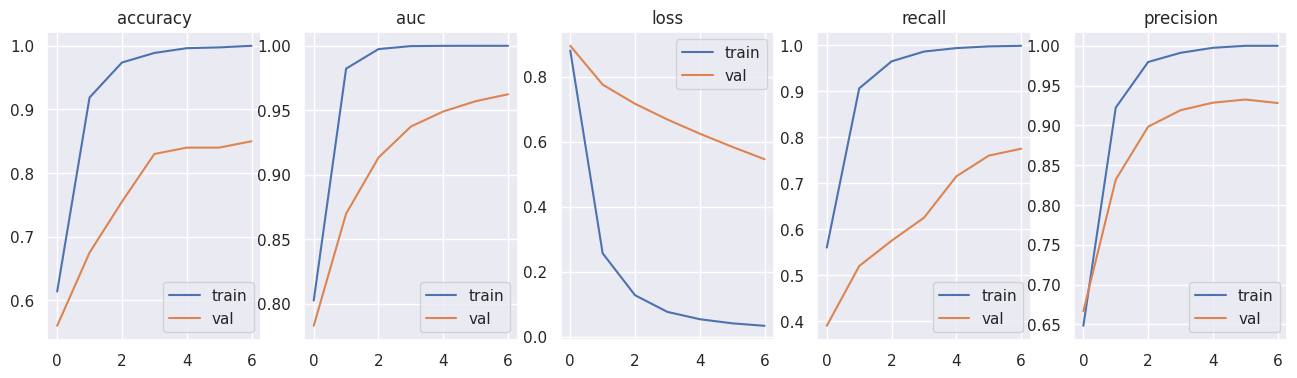

In [21]:
fig, axes = plt.subplots(1,5,figsize=(16,4))
lst = ['accuracy','auc','loss','recall','precision']
for i in range(len(lst)):
    axes[i].set_title(lst[i])
    sns.lineplot(df_hostory,x='epochs',y=lst[i],label='train',ax=axes[i])
    sns.lineplot(df_hostory,x='epochs',y='val_'+lst[i],label='val',ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
plt.show()

In [22]:
data_test = df_dataest.loc[df_dataest.index.isin(data.index)==False]
data_test = data_test.sample(len(data_test),random_state=42)
data_test['labels'].value_counts()

labels
2    1999
1    1973
0    1967
Name: count, dtype: int64

In [23]:
X_test_img = load_data(data_test['image_path'],(image_w_h,image_w_h))
X_test = X_test_img/255.0
y_test = to_y_data(data_test['labels'].to_list(),3)

print('X_test',X_test.shape,'y_test',y_test.shape)

(5939, 256, 256, 3)
X_test (5939, 256, 256, 3) y_test (5939, 3)


In [24]:
lst_preds = []

In [25]:
lst_preds.append(model.predict(X_test[:1000],verbose=0))
lst_preds.append(model.predict(X_test[1000:2000],verbose=0))
lst_preds.append(model.predict(X_test[2000:3000],verbose=0))
lst_preds.append(model.predict(X_test[3000:4000],verbose=0))
lst_preds.append(model.predict(X_test[4000:5000],verbose=0))
lst_preds.append(model.predict(X_test[5000:],verbose=0))

In [26]:
preds = None
pred_labels = None
for i in range(6):
    if i==0:
        pred_labels = np.argmax(lst_preds[i],axis=1)
        preds = lst_preds[i]
    else:
        pred_labels = np.append(pred_labels,np.argmax(lst_preds[i],axis=1))
        preds = np.append(preds,lst_preds[i],axis=0)

In [27]:
print(pred_labels.shape)
print(preds.shape)

(5939,)
(5939, 3)


In [28]:
true_labels = np.argmax(y_test,axis=1)

In [29]:
print('accuracy ',accuracy_score(true_labels,pred_labels))
print('recall   ',recall_score(true_labels,pred_labels,average='micro'))
print('precision',precision_score(true_labels,pred_labels,average='micro'))
print('roc_auc  ',roc_auc_score(y_test,preds,average='micro',multi_class='ovr'))

accuracy  0.8346522983667284
recall    0.8346522983667284
precision 0.8346522983667284
roc_auc   0.9360827828616586


In [30]:
import shap

In [31]:
class_names = [lst_labels[lbl] for lbl in true_labels]

In [37]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = (x.copy()/255.0)
    return model(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_train_img[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker,output_names=lst_labels)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X_test_img[:20], max_evals=100, batch_size=50)

PartitionExplainer explainer: 21it [01:30,  5.01s/it]                        


true pneumonia
pred pneumonia
Probability [0.22150365 0.31095162 0.46754467]


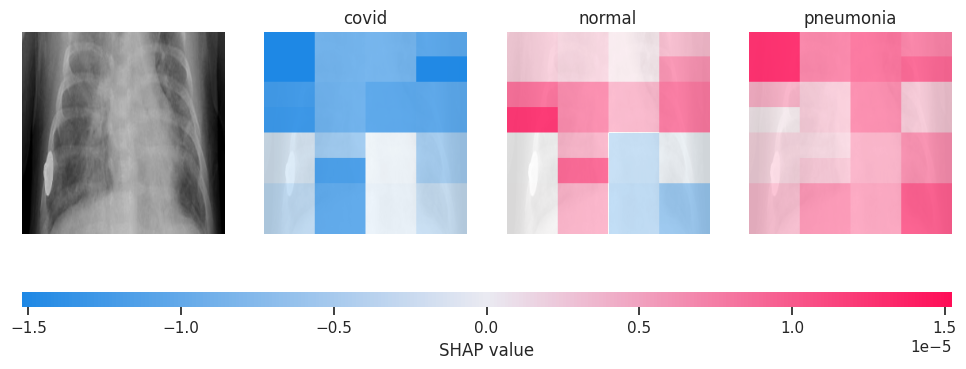

true pneumonia
pred pneumonia
Probability [0.22574581 0.31242535 0.4618289 ]


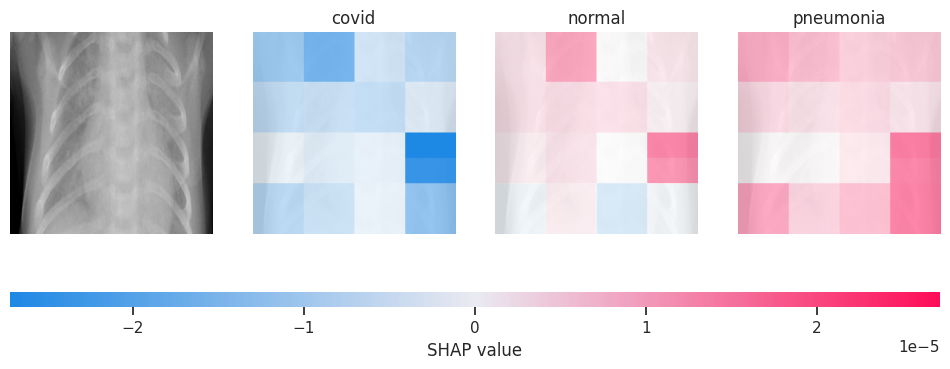

true normal
pred normal
Probability [0.0929092  0.6974861  0.20960478]


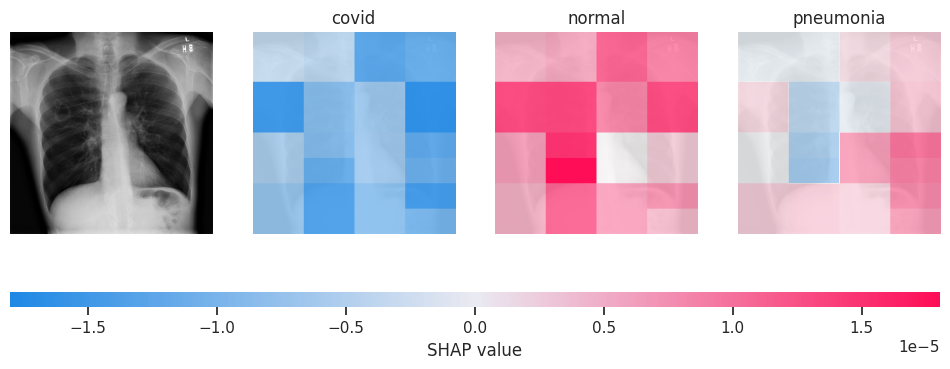

true pneumonia
pred normal
Probability [0.09271404 0.45719194 0.450094  ]


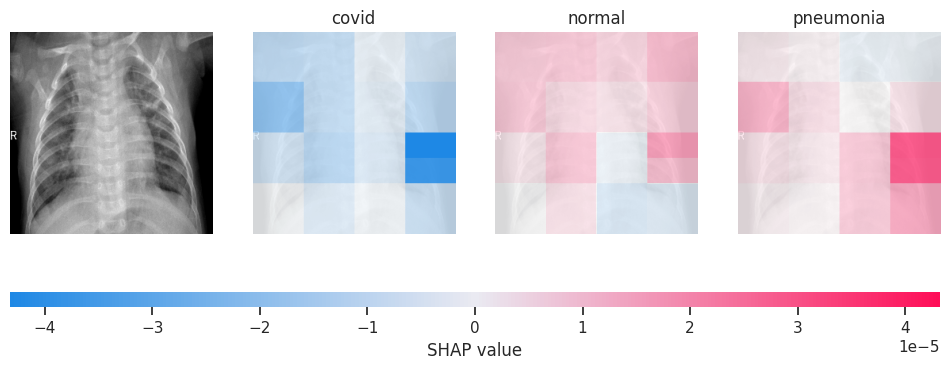

true normal
pred normal
Probability [0.26244798 0.5198493  0.21770272]


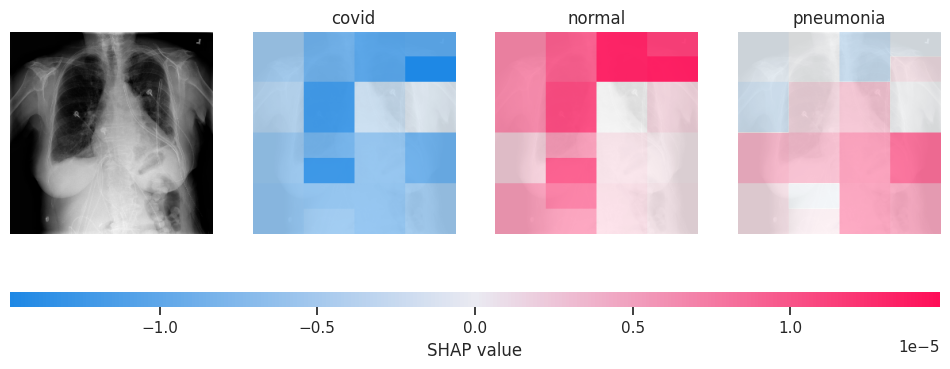

true normal
pred normal
Probability [0.07427859 0.6612008  0.26452062]


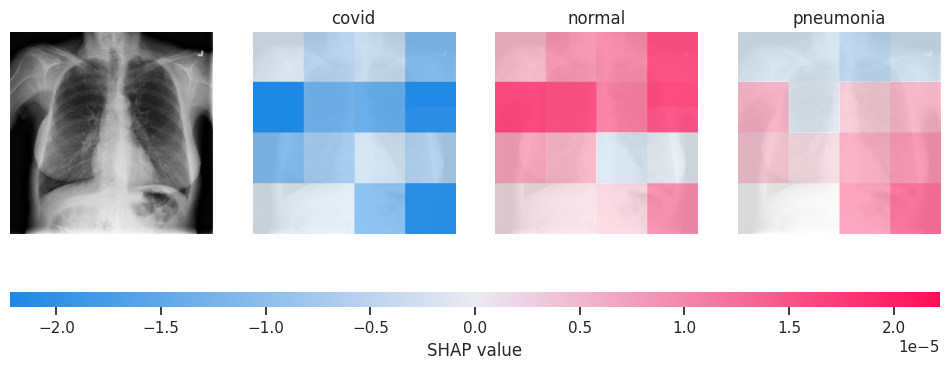

true pneumonia
pred pneumonia
Probability [0.17610504 0.34806463 0.4758303 ]


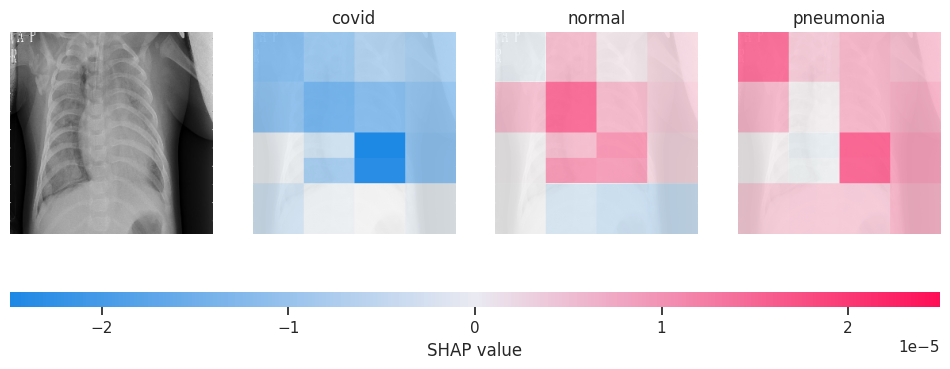

true normal
pred normal
Probability [0.15725295 0.650388   0.1923591 ]


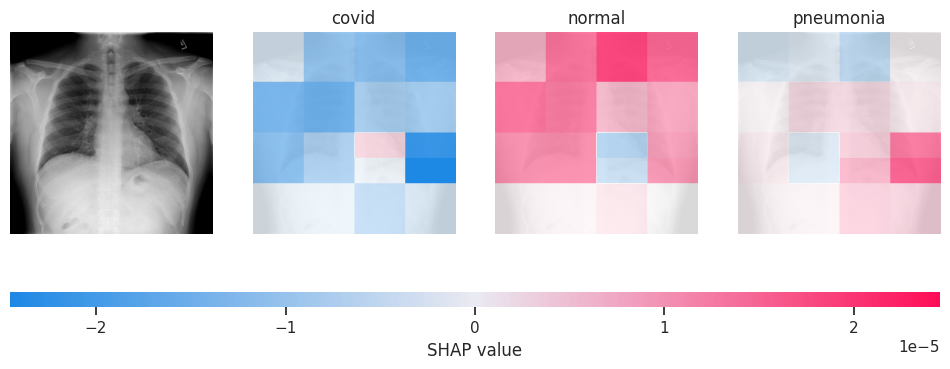

true pneumonia
pred pneumonia
Probability [0.09507674 0.3433212  0.56160206]


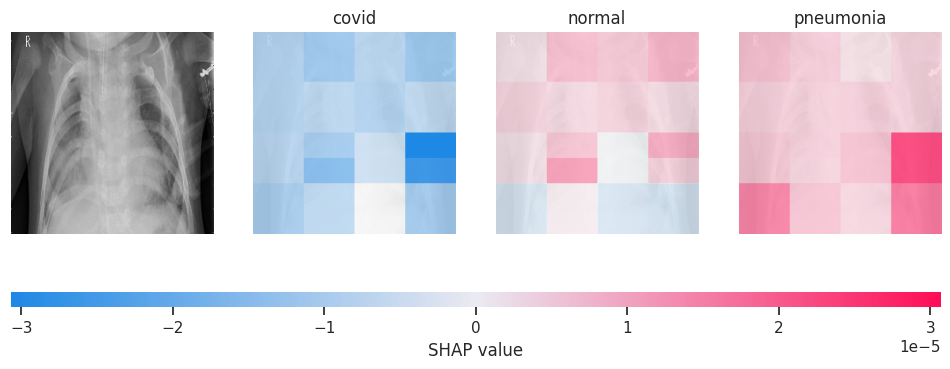

true normal
pred normal
Probability [0.26257247 0.5162982  0.22112931]


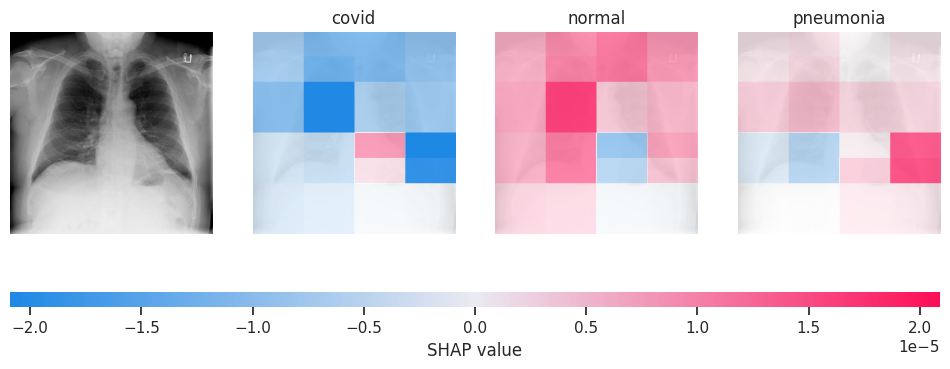

true normal
pred normal
Probability [0.2603144 0.4442328 0.2954528]


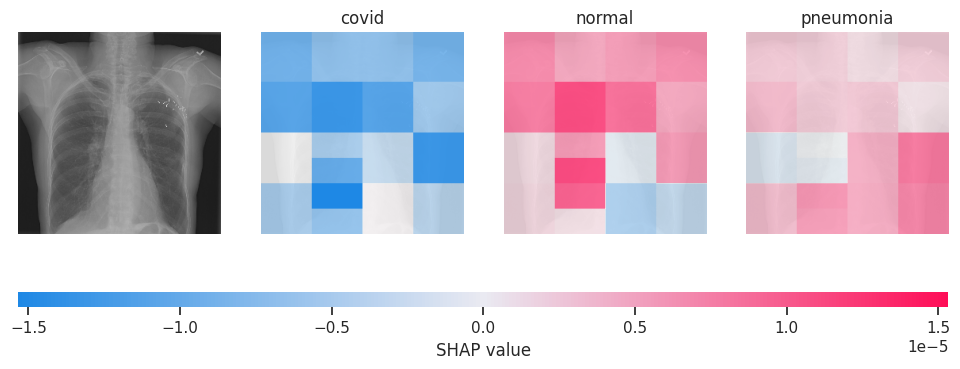

true normal
pred normal
Probability [0.16936111 0.6346738  0.19596505]


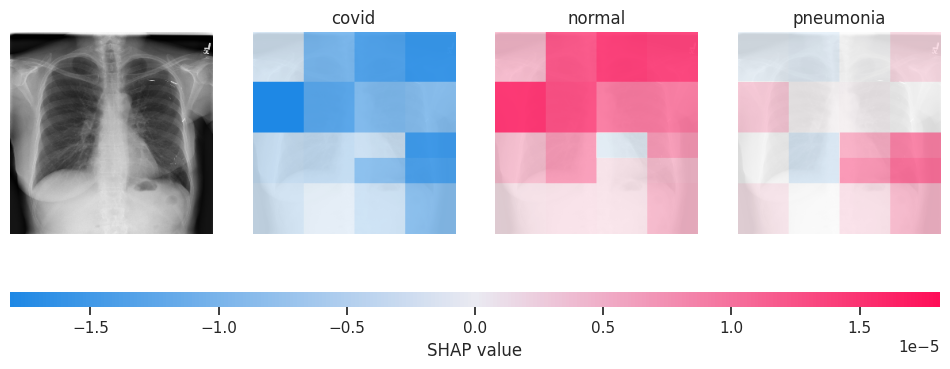

true covid
pred covid
Probability [0.5503813  0.19940509 0.25021365]


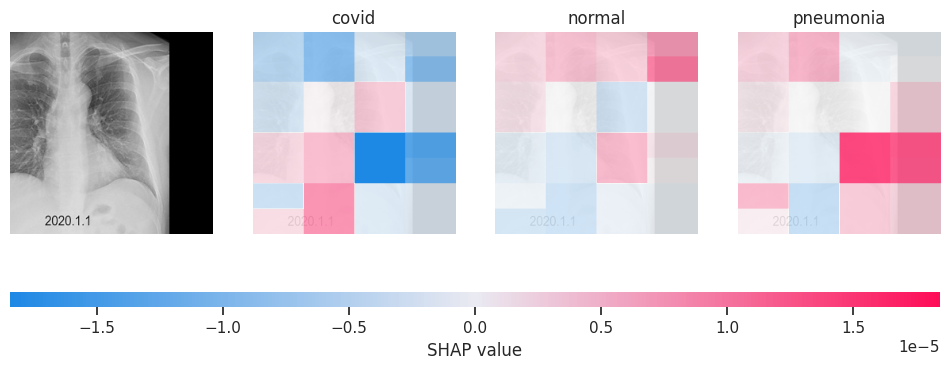

true covid
pred covid
Probability [0.6077769  0.27578375 0.11643932]


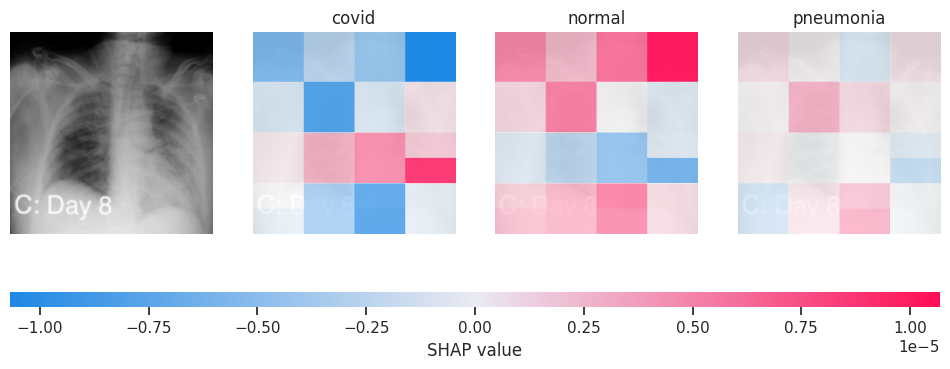

true covid
pred covid
Probability [0.3818914  0.363864   0.25424454]


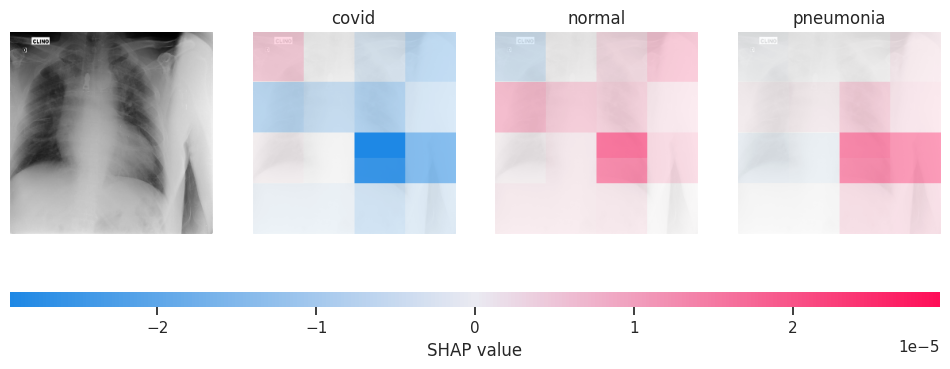

true covid
pred normal
Probability [0.2839906  0.5505219  0.16548754]


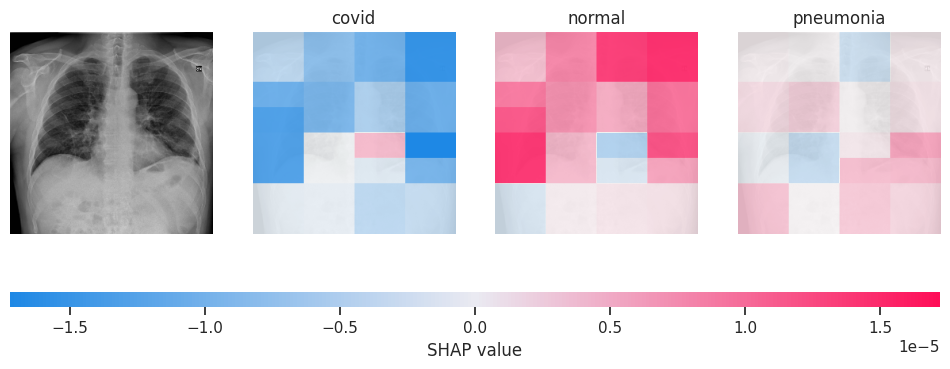

true normal
pred normal
Probability [0.17490226 0.5989809  0.22611691]


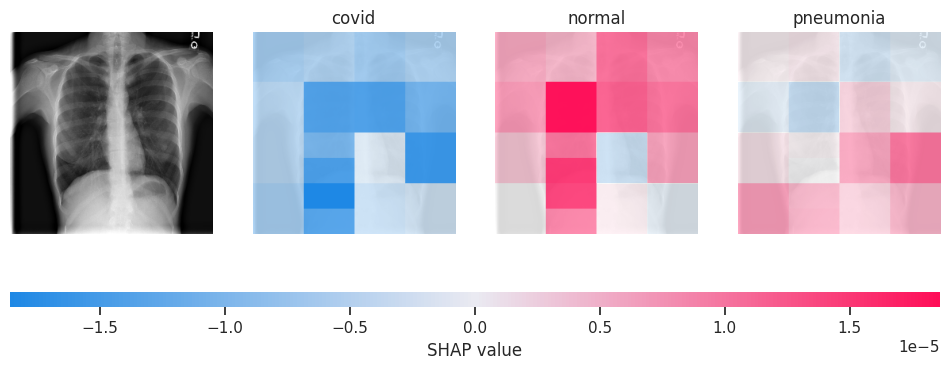

true normal
pred normal
Probability [0.25784758 0.6077439  0.13440846]


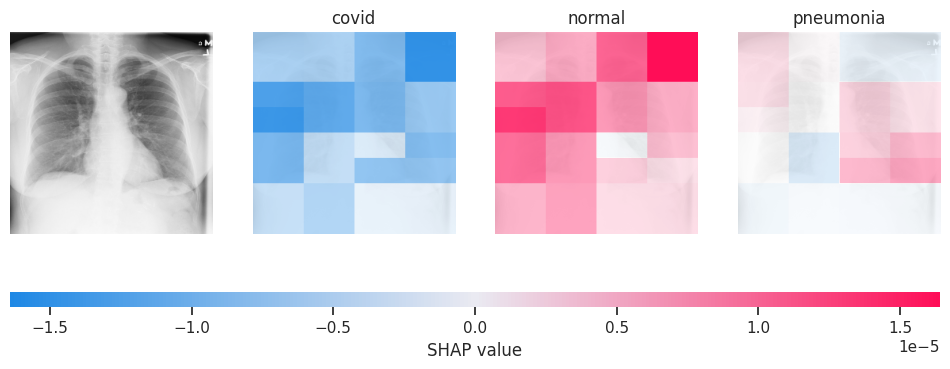

true covid
pred covid
Probability [0.56228215 0.24948657 0.1882313 ]


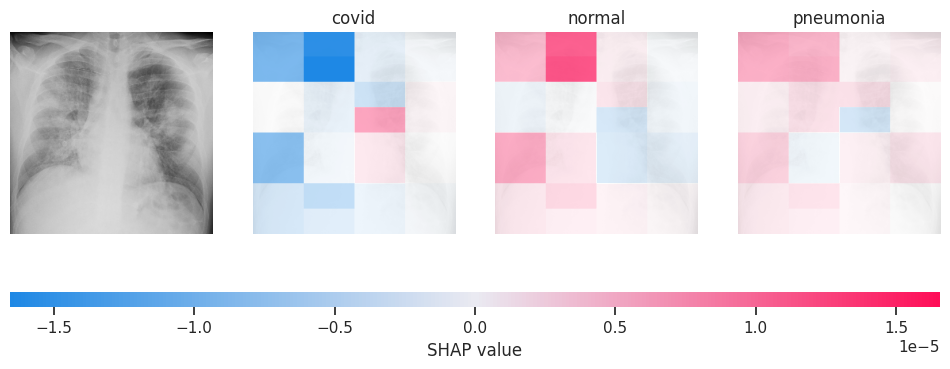

true pneumonia
pred pneumonia
Probability [0.07000001 0.40938902 0.520611  ]


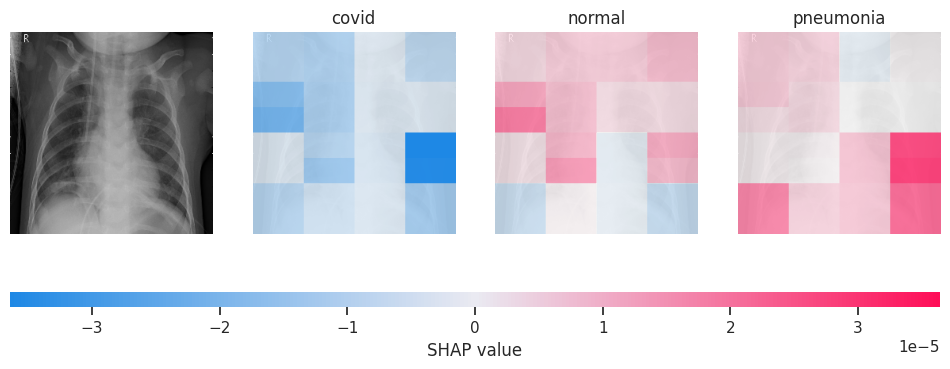

In [38]:
# output with shap values
for i in range(20):
    print('true',class_names[i])
    print('pred',lst_labels[pred_labels[i]])
    print('Probability',preds[i])
    shap.image_plot(shap_values[i])